In [94]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import utils
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.10f' % x)


## split dataset
use year 2015 as test, 2010 - 2014 as train
=> split of 86 / 14


In [95]:
# load data
df = utils.load_suicide_healthcare_gini_df()

# transform text columns to categories
df.country = pd.Categorical(df.country).codes
df.continent = pd.Categorical(df.continent).codes
df.sex = pd.Categorical(df.sex).codes
df.age = pd.Categorical(df.age).codes

test_df = df[df.year == 2015]
train_df = df[df.year < 2015]

In [96]:
print(f"{train_df.shape=} | {test_df.shape=}")

train_df.shape=(1788, 14) | test_df.shape=(276, 14)


/var/folders/v4/5kdk6t_57x3gwhsz8x8jl_900000gn/T/ipykernel_72735/554864916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),annot=True, ax=ax, vmin=-1, vmax=1)


<AxesSubplot: >

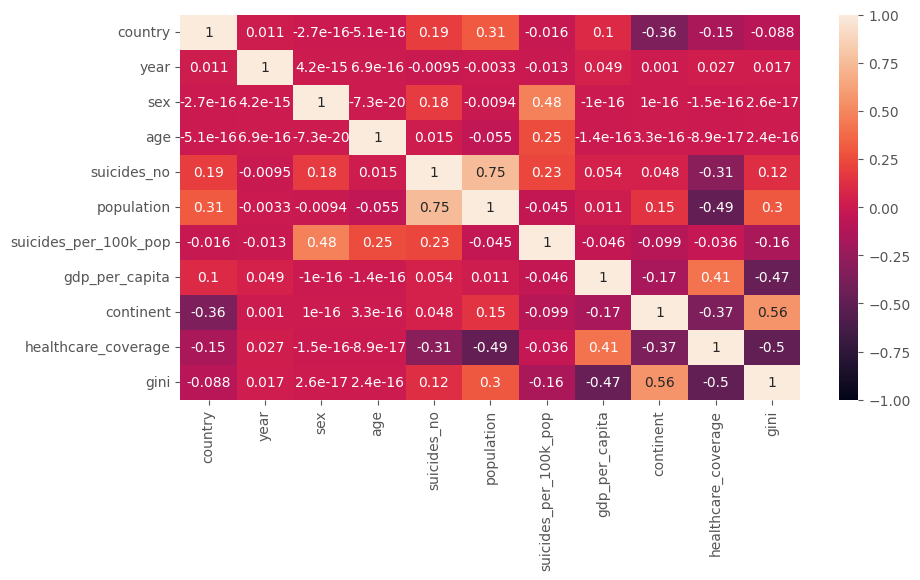

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(train_df.corr(),annot=True, ax=ax, vmin=-1, vmax=1)

In [98]:
df.head()


,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,generation,country_code,continent,healthcare_coverage,gini
0,0,2010,1,2,816,3076853,26.5200000000,"1,144,260,547,873",54887,Generation X,AUS,3,100.0000000000,34.7000000000
1,0,2010,1,5,151,582009,25.9400000000,"1,144,260,547,873",54887,Silent,AUS,3,100.0000000000,34.7000000000
2,0,2010,1,1,311,1606526,19.3600000000,"1,144,260,547,873",54887,Generation X,AUS,3,100.0000000000,34.7000000000
3,0,2010,1,4,360,2051197,17.5500000000,"1,144,260,547,873",54887,Silent,AUS,3,100.0000000000,34.7000000000
4,0,2010,1,0,222,1618860,13.7100000000,"1,144,260,547,873",54887,Millenials,AUS,3,100.0000000000,34.7000000000


## Prepare data

In [99]:
X_cols = ['country','continent','sex','age','year','gdp_per_capita','healthcare_coverage','gini','population']
X_train = train_df[X_cols].values
Y_train = train_df['suicides_no'].values

X_test = test_df[X_cols].values
Y_test = test_df['suicides_no'].values

In [100]:
# train_df.country.astype('category').cat.codes

In [101]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# create a standard scaler object and fit it to the training data
scaler = MinMaxScaler()#StandardScaler()
scaler.fit(X_train)

# transform the training and test data using the scaler
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## Linear regression model

In [102]:
#Import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

linear_model = LinearRegression(positive=False)
linear_model.fit(X_train_std, Y_train)

LinearRegression()

In [103]:
# prediction
y_pred = linear_model.predict(X_test_std)
mean_squared_error(y_true=Y_test, y_pred=y_pred)

378386.29195839464

(276,) (276,)


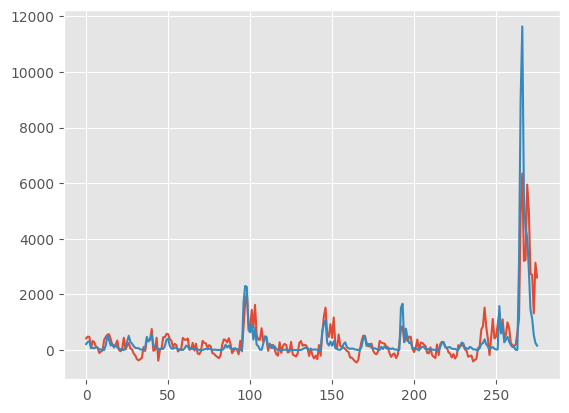

In [104]:
sns.lineplot(y_pred)
sns.lineplot(Y_test)
print(y_pred.shape,Y_test.shape)

(<AxesSubplot: ylabel='gt'>,)

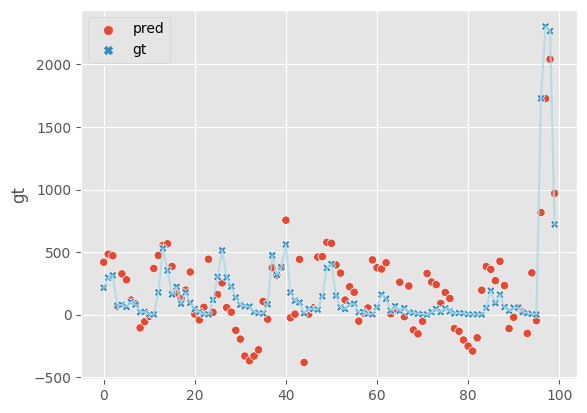

In [105]:
# look at an example
# X_test_std[:2,:]
linear_pred = linear_model.predict(X_test_std)
n_samples = 100
pred_df = pd.DataFrame({
    'pred' : linear_pred[:n_samples],
    'gt': Y_test[:n_samples]
})
sns.scatterplot(pred_df, markers=True)
sns.lineplot(pred_df['gt'], color='lightblue', alpha=.8),
# sns.lineplot(pred)
# sns.lineplot(Y_test[:5])
# X_test.shape

model looks ok, interestingly it predicts 0 partwise -> how to prevent? possible?

In [106]:
# subset = train_df[X_cols]
# subset[subset.population > 20_000_000]

## Decision tree regressor

In [107]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
dtr_model = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
dtr_model.fit(X_train_std, Y_train)

DecisionTreeRegressor(random_state=0)

In [108]:
# look at an example
# X_test_std[:2,:]
dtr_pred = dtr_model.predict(X_test_std)


In [109]:
from sklearn.metrics import mean_absolute_error
# calc avg distance
linear_mse = mean_squared_error(y_true=Y_test, y_pred=linear_pred)
dtr_mse = mean_squared_error(y_true=Y_test, y_pred=dtr_pred)
print(f"{linear_mse=} | {dtr_mse=}")
linear_mae = mean_absolute_error(y_true=Y_test, y_pred=linear_pred)
dtr_mae = mean_absolute_error(y_true=Y_test, y_pred=dtr_pred)
print(f"{linear_mae=} | {dtr_mae=}")

linear_mse=378386.29195839464 | dtr_mse=7821.351449275362
linear_mae=308.50891367827575 | dtr_mae=34.51086956521739


## MLP model 

In [110]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(
    hidden_layer_sizes=[512,256,64,8],
    max_iter=3000,
    activation='relu')
mlp_model.fit(X_train_std,Y_train)

MLPRegressor(hidden_layer_sizes=[512, 256, 64, 8], max_iter=3000)

<AxesSubplot: >

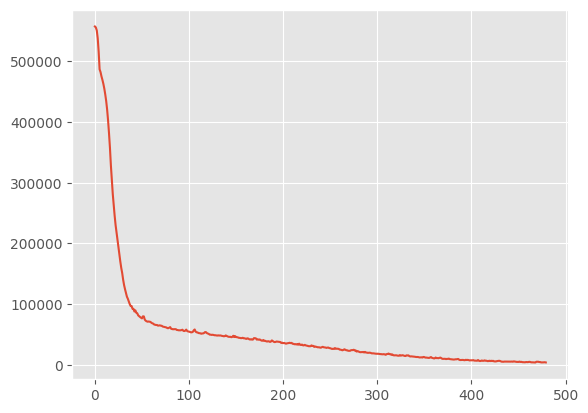

In [111]:
# plot loss
sns.lineplot(mlp_model.loss_curve_)

# load saved custom mlp models

In [112]:
import torch
from models import SuicideRegressorBN

saved_model = torch.load("torch_models/bn_1.pickle")
model = SuicideRegressorBN(in_features=9)
model.load_state_dict(saved_model.state_dict())

_ = model.eval()

In [113]:
# make predictions with saved model
pred = model(torch.tensor(X_test_std).float()).detach().numpy()
custom_mlp_bn_pred = pred[:,0]


# XGB boost model

In [114]:
from xgboost.sklearn import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train_std,Y_train)
xgb_pred = xgb_model.predict(X_test_std)


# Compare models


In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, max_error

# Make prediction
# pred = mlp_model.predict(X_test_std)
#
# Calculate accuracy and error metrics
#
# test_set_rsquared = mlp_model.score(X_test_std, Y_test)
# test_set_rmse = np.sqrt(mean_squared_error(Y_test, pred))
# test_set_mae = mean_absolute_error(y_true=Y_test,y_pred=pred)
# print('train: ', mean_absolute_error(y_true=Y_train,y_pred=mlp_model.predict(X_train_std)))
# print('test: ' ,test_set_mae)
# #
# # Print R_squared and RMSE value
# #
# print('R_squared value: ', test_set_rsquared)
# print('RMSE: ', test_set_rmse)
sklearn_mlp_pred = mlp_model.predict(X_test_std)
metrics = [mean_squared_error, mean_absolute_error, median_absolute_error, max_error]
model_preds = {
    'linear': linear_pred,
    'dtr': dtr_pred,
    'sklearn_mlp': sklearn_mlp_pred,
    'custom_mlp_bn_pred': custom_mlp_bn_pred,
    'xgb_pred': xgb_pred,
}


for metric in metrics:
    print(f"{metric.__name__} eval:")
    for model, pred in model_preds.items():
        score = metric(y_true=Y_test, y_pred=pred)
        print(f"{model}: {score}")
    print('-'*10)

# mlp_mse = mean_squared_error(y_true=Y_test, y_pred=mlp_pred)
# linear_mse = mean_squared_error(y_true=Y_test, y_pred=linear_pred)
# dtr_mse = mean_squared_error(y_true=Y_test, y_pred=dtr_pred)
# print(f"{linear_mse=} | {dtr_mse=} | {mlp_mse=}")
# linear_mae = mean_absolute_error(y_true=Y_test, y_pred=linear_pred)
# dtr_mae = mean_absolute_error(y_true=Y_test, y_pred=dtr_pred)
# mlp_mae = mean_absolute_error(y_true=Y_test, y_pred=mlp_pred)
# print(f"{linear_mae=} | {dtr_mae=} | {mlp_mae=}")


mean_squared_error eval:
linear: 378386.29195839464
dtr: 7821.351449275362
sklearn_mlp: 12324.011165962092
custom_mlp_bn_pred: 4001.4091741490615
xgb_pred: 9224.465468064916
----------
mean_absolute_error eval:
linear: 308.50891367827575
dtr: 34.51086956521739
sklearn_mlp: 64.62173496720179
custom_mlp_bn_pred: 34.204652908487596
xgb_pred: 42.01274177345677
----------
median_absolute_error eval:
linear: 193.6374227908906
dtr: 10.0
sklearn_mlp: 31.74437059489392
custom_mlp_bn_pred: 17.990802764892578
xgb_pred: 14.751846313476562
----------
max_error eval:
linear: 5285.873535036203
dtr: 832.0
sklearn_mlp: 607.4045958097763
custom_mlp_bn_pred: 337.45758056640625
xgb_pred: 891.397216796875
----------


(<AxesSubplot: >,)

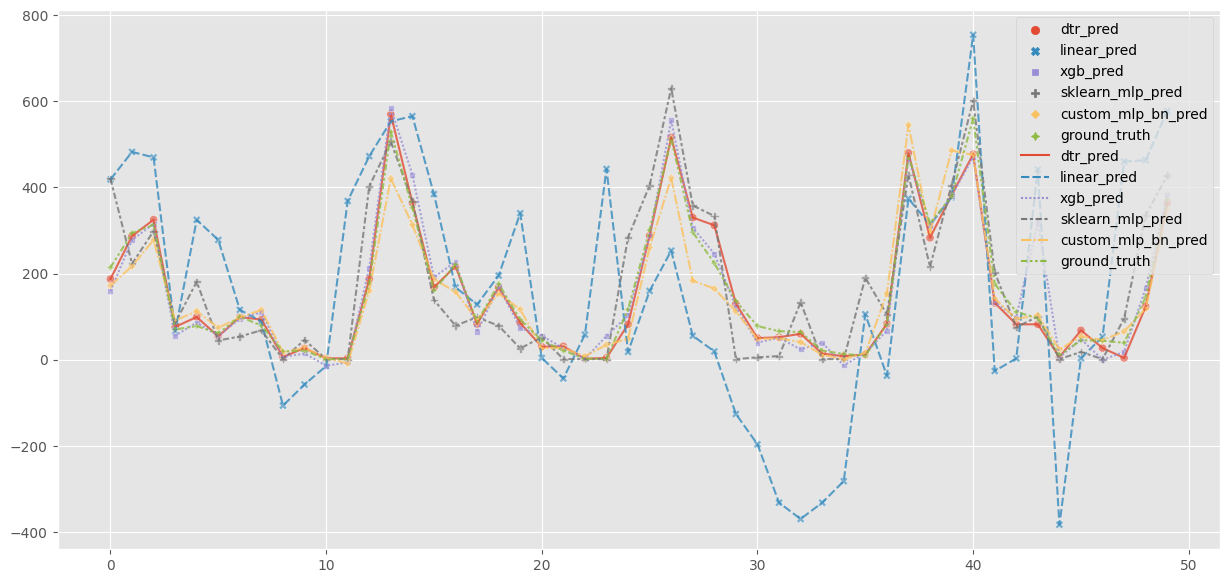

In [116]:
n_samples = 50
pred_df = pd.DataFrame({
    'dtr_pred' : dtr_pred[:n_samples],
    'linear_pred' : linear_pred[:n_samples],
    'xgb_pred': xgb_pred[:n_samples],
    'sklearn_mlp_pred' : sklearn_mlp_pred[:n_samples],
    'custom_mlp_bn_pred' : custom_mlp_bn_pred[:n_samples],
    'ground_truth': Y_test[:n_samples]
})


fig,ax = plt.subplots(figsize=(15,7))
sns.scatterplot(pred_df, markers=True, alpha=.6,ax=ax)
sns.lineplot(pred_df, alpha=.8, ax=ax),
# sns.lineplot(pred)
# sns.lineplot(Y_test[:5])
# X_test.shape
